<a href="https://colab.research.google.com/github/kevintsi/deep_learning_course/blob/main/project_dl_covid_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Deep Learning : Détection de COVID

In [45]:
import sys
import os
import shutil
import time
import pickle
import numpy as np

# Deep Learning Librairies
import tensorflow as tf
import keras.preprocessing.image as kpi
import keras.layers as kl
import keras.optimizers as ko
import keras.backend as k
import keras.models as km
import keras.applications as ka

# Visualisaiton des données
from matplotlib import pyplot as plt

In [46]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15434691463549480450
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9449163584490032337
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [47]:
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)


GPU


In [48]:
data_dir = 'drive/MyDrive/' # chemin d'accès aux données

N_train = 400
N_val = 200

data_dir_sub = data_dir+'covid_detection_sample_%d_Ntrain_%d_Nval' %(N_train, N_val)

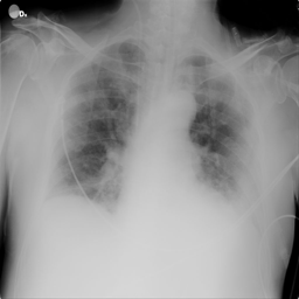

In [49]:
img = kpi.load_img(data_dir_sub+'/train/COVID/COVID-1.png')
img

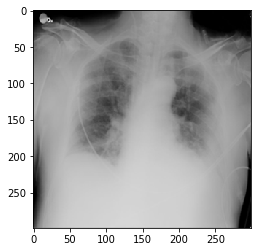

In [50]:
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

In [51]:
x_0 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/COVID/COVID-1.png"))
x_1 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/COVID/COVID-2.png"))
x_0.shape, x_1.shape

((299, 299, 3), (299, 299, 3))

In [52]:
datagen = kpi.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [53]:
img_width = 299
img_height = 299

img = kpi.load_img(data_dir_sub+"/train/COVID/COVID-1.png")
x = kpi.img_to_array(img)  
x_ = x.reshape((1,) + x.shape)

if not(os.path.isdir(data_dir_sub+"/preprocessing_example")):
    os.mkdir(data_dir_sub+"/preprocessing_example")

    i = 0
    for batch in datagen.flow(x_, batch_size=1,save_to_dir=data_dir_sub+"/preprocessing_example", save_prefix='covid', save_format='png'):
        i += 1
        if i > 7:
            break  

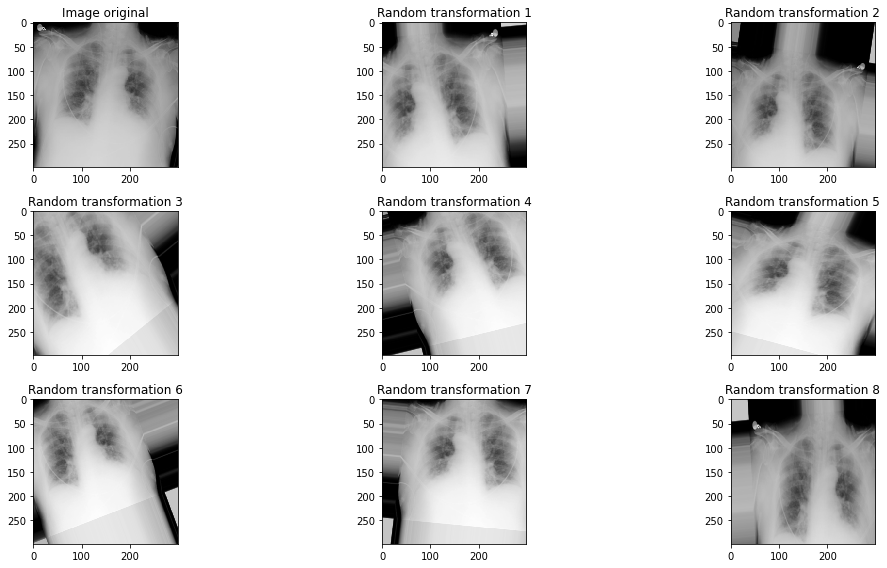

In [54]:
X_list=[]
for f in os.listdir(data_dir_sub+"/preprocessing_example"):
    X_list.append(kpi.img_to_array(kpi.load_img(data_dir_sub+"/preprocessing_example/"+f)))


fig=plt.figure(figsize=(16,8))
fig.patch.set_alpha(0)
ax = fig.add_subplot(3,3,1)
ax.imshow(x/255, interpolation="nearest")
ax.set_title("Image original")
for i,xt in enumerate(X_list):
    ax = fig.add_subplot(3,3,i+2)
    ax.imshow(xt/255, interpolation="nearest")
    ax.set_title("Random transformation %d" %(i+1))
plt.tight_layout()
plt.savefig("covid_transformation.png", dpi=100, bbox_to_anchor="tight", facecolor=fig.get_facecolor())
plt.show()

In [55]:
epochs = 10
batch_size=20

In [56]:
# this is the augmentation configuration we will use for training
train_datagen = kpi.ImageDataGenerator(
        rescale=1./255,
)

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = kpi.ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        data_dir_sub+"/train/",  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = valid_datagen.flow_from_directory(
        data_dir_sub+"/validation/",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [57]:
model_conv = km.Sequential()
model_conv.add(kl.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), data_format="channels_last"))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(32, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(64, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_conv.add(kl.Dense(64))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.Dropout(0.5))
model_conv.add(kl.Dense(1))
model_conv.add(kl.Activation('sigmoid'))

model_conv.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


model_conv.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 297, 297, 32)      896       
                                                                 
 activation_15 (Activation)  (None, 297, 297, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 148, 148, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 146, 146, 32)      9248      
                                                                 
 activation_16 (Activation)  (None, 146, 146, 32)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                 

In [58]:
ts = time.time()
model_conv.fit(train_generator, steps_per_epoch=N_train // batch_size, epochs=epochs,
       validation_data=validation_generator,validation_steps=N_val // batch_size)
te = time.time()
t_learning_conv_simple_model = te-ts
print("Learning TIme for %d epochs : %d seconds"%(epochs,t_learning_conv_simple_model))
model_conv.save(data_dir_sub+'/'+MODE+'_models_convolutional_network_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

Epoch 1/10
20/20 [==============================] - 5s 193ms/step - loss: -85404.3984 - accuracy: 0.2575 - val_loss: -428219.0312 - val_accuracy: 0.2500
Epoch 2/10
20/20 [==============================] - 4s 184ms/step - loss: -1882505.6250 - accuracy: 0.2500 - val_loss: -4498531.5000 - val_accuracy: 0.2500
Epoch 3/10
20/20 [==============================] - 4s 181ms/step - loss: -9236109.0000 - accuracy: 0.2500 - val_loss: -16234804.0000 - val_accuracy: 0.2500
Epoch 4/10
20/20 [==============================] - 4s 181ms/step - loss: -24718548.0000 - accuracy: 0.2500 - val_loss: -41819360.0000 - val_accuracy: 0.2500
Epoch 5/10
20/20 [==============================] - 4s 182ms/step - loss: -62779312.0000 - accuracy: 0.2500 - val_loss: -94872280.0000 - val_accuracy: 0.2500
Epoch 6/10
20/20 [==============================] - 4s 182ms/step - loss: -130432184.0000 - accuracy: 0.2500 - val_loss: -170839360.0000 - val_accuracy: 0.2500
Epoch 7/10
20/20 [==============================] - 4s 184

In [40]:
ts = time.time()
score_conv_val = model_conv.evaluate_generator(validation_generator, N_val /batch_size, verbose=1)
score_conv_train = model_conv.evaluate_generator(train_generator, N_train / batch_size, verbose=1)
te = time.time()
t_prediction_conv_simple_model = te-ts
print('Train accuracy:', score_conv_train[1])
print('Validation accuracy:', score_conv_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_conv_simple_model )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


10/10 [==============================] - 1s 115ms/step - loss: -1039728704.0000 - accuracy: 0.2500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


20/20 [==============================] - 2s 114ms/step - loss: -1021838976.0000 - accuracy: 0.2506
Train accuracy: 0.2506265640258789
Validation accuracy: 0.25
Time Prediction: 4.14 seconds


In [41]:
model_VGG16_without_top = ka.vgg16.VGG16(include_top=False, weights='imagenet')
model_VGG16_without_top.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [42]:
features_train_path = data_dir_sub+'/features_train.npy' 
features_validation_path = data_dir_sub+'/features_validation.npy' 

if os.path.isfile(features_train_path) and os.path.isfile(features_validation_path):
    print("Load Features")
    features_train = np.load(open(features_train_path, "rb"))
    features_validation = np.load(open(features_validation_path, "rb"))
    
else:
    print("Generate Features")
    datagen = kpi.ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
            data_dir_sub+"/train",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,  # this means our generator will only yield batches of data, no labels
            shuffle=False)  
    features_train = model_VGG16_without_top.predict(generator, N_train / batch_size,  verbose = 1)
    # save the output as a Numpy array
    np.save(open(features_train_path, 'wb'), features_train)

    
    generator = datagen.flow_from_directory(
        data_dir_sub+"/validation",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)
    features_validation = model_VGG16_without_top.predict_generator(generator, N_val / batch_size,  verbose = 1)
    # save the output as a Numpy array
    np.save(open(features_validation_path, 'wb'), features_validation)

Generate Features
Found 400 images belonging to 4 classes.
20/20 [==============================] - 8s 398ms/step
Found 200 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


10/10 [==============================] - 4s 393ms/step


In [43]:
model_VGG_fcm = km.Sequential()
model_VGG_fcm.add(kl.Flatten(input_shape=features_train.shape[1:]))
model_VGG_fcm.add(kl.Dense(64, activation='relu'))
model_VGG_fcm.add(kl.Dropout(0.5))
model_VGG_fcm.add(kl.Dense(1, activation='sigmoid'))

model_VGG_fcm.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_VGG_fcm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 41472)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                2654272   
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,654,337
Trainable params: 2,654,337
Non-trainable params: 0
_________________________________________________________________


In [44]:
# On créer des vecteurs labels

train_labels = np.array([0] * int((N_train/2)) + [1] * int((N_train/2)))
validation_labels = np.array([0] * int((N_val/2)) + [1] * int((N_val/2)))

model_VGG_fcm.fit(features_train, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(features_validation, validation_labels))
t_learning_VGG_fcm = te-ts

Epoch 1/10
20/20 [==============================] - 1s 19ms/step - loss: 2.8211 - accuracy: 0.5850 - val_loss: 0.5916 - val_accuracy: 0.6450
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.6459 - accuracy: 0.6175 - val_loss: 0.6557 - val_accuracy: 0.5450
Epoch 3/10
20/20 [==============================] - 0s 9ms/step - loss: 0.8112 - accuracy: 0.5875 - val_loss: 0.6287 - val_accuracy: 0.6200
Epoch 4/10
20/20 [==============================] - 0s 8ms/step - loss: 0.5755 - accuracy: 0.6675 - val_loss: 0.5811 - val_accuracy: 0.8400
Epoch 5/10
20/20 [==============================] - 0s 11ms/step - loss: 0.6039 - accuracy: 0.6750 - val_loss: 0.4533 - val_accuracy: 0.8550
Epoch 6/10
20/20 [==============================] - 0s 10ms/step - loss: 0.6119 - accuracy: 0.7175 - val_loss: 0.4203 - val_accuracy: 0.8550
Epoch 7/10
20/20 [==============================] - 0s 9ms/step - loss: 0.5359 - accuracy: 0.7375 - val_loss: 0.3831 - val_accuracy: 0.8850
Epoch 8/10
20/20 

In [59]:
model_VGG_fcm.save_weights(data_dir_sub+'/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

In [60]:
ts = time.time()
score_VGG_fcm_val = model_VGG_fcm.evaluate(features_validation, validation_labels)
score_VGG_fcm_train = model_VGG_fcm.evaluate(features_train, train_labels)
te = time.time()
t_prediction_VGG_fcm = te-ts
print('Train accuracy:', score_VGG_fcm_train[1])
print('Validation accuracy:', score_VGG_fcm_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_fcm)

13/13 [==============================] - 0s 5ms/step - loss: 0.4183 - accuracy: 0.7625
Train accuracy: 0.762499988079071
Validation accuracy: 0.7450000047683716
Time Prediction: 0.42 seconds


In [62]:
# build the VGG16 network
model_VGG16_without_top = ka.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(299,299,3))
print('Model loaded.')

Model loaded.


In [63]:
# build a classifier model to put on top of the convolutional model
top_model = km.Sequential()
top_model.add(kl.Flatten(input_shape=model_VGG16_without_top.output_shape[1:]))
top_model.add(kl.Dense(64, activation='relu'))
top_model.add(kl.Dropout(0.5))
top_model.add(kl.Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning

top_model.load_weights(data_dir_sub+'/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

In [64]:
# add the model on top of the convolutional base
model_VGG_LastConv_fcm = km.Model(inputs=model_VGG16_without_top.input, outputs=top_model(model_VGG16_without_top.output))

model_VGG_LastConv_fcm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [65]:
for layer in model_VGG_LastConv_fcm.layers[:15]:
    layer.trainable = False

In [66]:
# prepare data augmentation configuration
train_datagen = kpi.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    data_dir_sub+"/train/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    data_dir_sub+"/validation/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [68]:
model_VGG_LastConv_fcm.compile(loss='binary_crossentropy',
              optimizer=ko.gradient_descent_v2.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


# fine-tune the model
ts = time.time()
model_VGG_LastConv_fcm.fit(
    train_generator,
    steps_per_epoch=N_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=N_val // batch_size)
te = time.time()
t_learning_VGG_LastConv_fcm = te-ts

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
20/20 [==============================] - 18s 840ms/step - loss: -404.6340 - accuracy: 0.2525 - val_loss: -53352.0703 - val_accuracy: 0.2500
Epoch 2/10
20/20 [==============================] - 17s 837ms/step - loss: nan - accuracy: 0.2200 - val_loss: nan - val_accuracy: 0.2500
Epoch 3/10
20/20 [==============================] - 17s 836ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2500
Epoch 4/10
20/20 [==============================] - 17s 840ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2500
Epoch 5/10
20/20 [==============================] - 17s 842ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2500
Epoch 6/10
20/20 [==============================] - 17s 845ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2500
Epoch 7/10
20/20 [==============================] - 17s 839ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2500
Epoch 8/10
20/20 [=========

In [69]:
ts = time.time()
score_VGG_LastConv_fcm_val = model_VGG_LastConv_fcm.evaluate_generator(validation_generator, N_val // batch_size)
score_VGG_LastConv_fcm_train = model_VGG_LastConv_fcm.evaluate_generator(train_generator, N_train // batch_size)

te = time.time()
t_prediction_VGG_LastConv_fcm = te-ts
print('Train accuracy:', score_VGG_LastConv_fcm_val[1])
print('Validation accuracy:', score_VGG_LastConv_fcm_train[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_LastConv_fcm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Train accuracy: 0.25
Validation accuracy: 0.25
Time Prediction: 17.09 seconds


In [71]:
data_dir_test = data_dir_sub+'/test/'
N_test = len(os.listdir(data_dir_test))

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    data_dir_test,
    #data_dir_sub+"/train/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

test_prediction = model_VGG_LastConv_fcm.predict(test_generator, N_test // batch_size)

Found 300 images belonging to 4 classes.


In [74]:
images_test = [data_dir_test+k for k in os.listdir(data_dir_test)][:9]
print(images_test)
x_test  = [kpi.img_to_array(kpi.load_img(image_test))/255 for image_test in images_test]  # this is a PIL image

fig = plt.figure(figsize=(10,10))
for k in range(9):
    ax = fig.add_subplot(3,3,k+1)
    ax.imshow(x_test[k], interpolation='nearest')
    pred = test_prediction[k]
    if pred >0.5:
        title = "Probability for non-covid : %.1f" %(pred*100)
    else:
        title = "Probability for covid : %.1f" %((1-pred)*100)
    ax.set_title(title)
plt.show()

['drive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/test/COVID', 'drive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/test/Opacite_Pulmonaire', 'drive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/test/Pneumonie_Virale', 'drive/MyDrive/covid_detection_sample_400_Ntrain_200_Nval/test/Normal']


IsADirectoryError: ignored